# Лабораторная работа №2 Парсинг


### **Теоретический материал к Лабораторной работе №2**

**Тема: Основы автоматизированного сбора данных из веб-источников**

#### **Введение: от веб-страницы к структурированным данным**

Современный Интернет представляет собой крупнейший в истории человечества источник информации. Однако эти данные, как правило, представлены в неструктурированном, человекочитаемом формате — в виде веб-страниц. Процесс автоматического извлечения данных с веб-сайтов и их преобразования в структурированный, машиночитаемый вид (например, в таблицу или базу данных) получил название **веб-парсинг** (от англ. *to parse* — анализировать, разбирать) или **веб-скрейпинг** (*to scrape* — соскребать).

Для выполнения этой задачи мы будем использовать экосистему из нескольких специализированных библиотек Python, каждая из которых выполняет свою строго определенную функцию. В данной работе мы сосредоточимся на двух основных инструментах для работы со статичными сайтами.

---

#### **1. Библиотека `requests`: Протокол взаимодействия с веб-сервером**

Любое взаимодействие в сети Интернет начинается с отправки запроса. Когда вы вводите адрес сайта в браузере, он отправляет HTTP-запрос к серверу, на котором этот сайт расположен. Сервер в ответ присылает HTML-документ, который браузер и отображает.

Библиотека `requests` является отраслевым стандартом в Python для выполнения этой задачи программным путем. Её основная функция — абстрагироваться от сложностей сетевых протоколов и предоставить простой интерфейс для отправки HTTP-запросов.

**Ключевые концепции и синтаксис:**

1.  **Отправка GET-запроса:** Основной метод, который мы используем, — `requests.get()`. Он эмулирует переход по URL-адресу в браузере.

    ```python
    import requests

    # URL-адрес целевого ресурса
    url = 'http://quotes.toscrape.com/'

    # Отправка запроса. Вся информация об ответе сервера будет храниться в объекте 'response'
    response = requests.get(url)
    ```

2.  **Объект ответа (`response`):** Результатом вызова `requests.get()` является объект, содержащий всю информацию об ответе сервера. Наиболее важные для нас атрибуты:
    *   `response.status_code`: Числовой код состояния HTTP. Успешный запрос возвращает код **200**. Коды, начинающиеся с 4 (например, 404 Not Found) или 5 (например, 500 Internal Server Error), свидетельствуют об ошибках. Проверка этого кода — обязательный шаг для написания надежного парсера.
    *   `response.text`: Содержимое ответа сервера в виде текстовой строки. В нашем случае это будет полный HTML-код запрошенной страницы.

    **Пример использования:**

    ```python
    if response.status_code == 200:
        print("Запрос выполнен успешно.")
        # Получаем HTML-код страницы
        html_content = response.text
        print("Длина полученного HTML-документа:", len(html_content), "символов.")
    else:
        print("Произошла ошибка при запросе. Код:", response.status_code)
    ```

На данном этапе `requests` свою задачу выполнил: мы получили "сырой" HTML-документ. Далее его необходимо проанализировать.

---

#### **2. Библиотека `BeautifulSoup`: Навигация по DOM-структуре документа**

HTML-документ — это не просто текст, а строго иерархическая структура, описываемая с помощью тегов. Эту структуру принято называть **DOM-деревом** (Document Object Model). Библиотека `BeautifulSoup` является мощнейшим инструментом для парсинга этого дерева. Она преобразует текстовую строку HTML в объектную модель, по которой можно осуществлять удобную навигацию и поиск.

**Ключевые концепции и синтаксис:**

1.  **Инициализация объекта ("создание супа"):** Первым шагом является создание экземпляра класса `BeautifulSoup`, который принимает на вход HTML-текст и название парсера.

    ```python
    from bs4 import BeautifulSoup

    # html_content - это строка, полученная от requests.text
    soup = BeautifulSoup(html_content, 'html.parser')
    ```

2.  **Поиск элементов:** `BeautifulSoup` предоставляет два основных метода для поиска тегов внутри DOM-дерева. Они используют **селекторы** — комбинации имени тега и его атрибутов (например, `class` или `id`).

    *   **`soup.find(tag, attributes)`**: Ищет **первый** элемент, соответствующий заданным критериям, и возвращает его как объект тега. Если ничего не найдено, возвращает `None`.

      **Синтаксис:**
      ```python
      # Поиск первого тега <h1>
      first_h1 = soup.find('h1')

      # Поиск первого тега <span> с атрибутом class='text'
      # ВАЖНО: 'class' - зарезервированное слово в Python, поэтому используется аргумент 'class_'
      first_quote_text = soup.find('span', class_='text')
      ```

    *   **`soup.find_all(tag, attributes)`**: Ищет **все** элементы, соответствующие критериям, и возвращает их в виде списка (`list`). Если ничего не найдено, возвращает пустой список.

      **Синтаксис:**
      ```python
      # Поиск всех тегов <div> с атрибутом class='quote'
      all_quote_containers = soup.find_all('div', class_='quote')

      # Итерация по результатам
      for container in all_quote_containers:
          # Внутри каждого найденного контейнера можно продолжать поиск
          author = container.find('small', class_='author')
          print(author.text)
      ```

3.  **Извлечение содержимого из найденных тегов:** После того как тег найден, из него можно извлечь полезную информацию.
    *   **`.text`**: Возвращает все текстовое содержимое внутри тега и его дочерних элементов в виде одной строки.
    *   **`tag['attribute_name']`**: Позволяет получить значение конкретного атрибута тега. Чаще всего используется для извлечения ссылок из атрибута `href` у тега `<a>`.

      **Пример использования:**
      ```python
      # Найдем тег с цитатой
      quote_element = soup.find('div', class_='quote')

      # Извлекаем текст цитаты
      text = quote_element.find('span', class_='text').text
      print("Текст цитаты:", text)

      # Извлекаем ссылку на автора (если она есть)
      author_link = quote_element.find('a') # Находим первый тег <a> внутри контейнера
      if author_link:
          href_value = author_link['href']
          print("Ссылка на страницу автора:", href_value)
      ```



Рассмотренный ранее подход с использованием библиотек `requests` и `BeautifulSoup` является высокоэффективным для работы со **статичными** веб-страницами. "Статичная" страница — это документ, HTML-код которого полностью формируется на сервере и доставляется клиенту в готовом виде. Однако значительная часть современного веба функционирует иначе.

**Динамические веб-сайты** активно используют технологию JavaScript для модификации своего содержимого непосредственно в браузере пользователя *после* первоначальной загрузки страницы. Это может быть подгрузка новостной ленты при прокрутке, отображение цен на авиабилеты после выбора маршрута, обновление графика погоды в реальном времени.

При попытке парсинга таких сайтов с помощью `requests`, мы получим лишь базовый HTML-шаблон, в котором искомые данные будут отсутствовать, поскольку JavaScript-код, ответственный за их загрузку и отображение, не будет исполнен.

Для решения этой фундаментальной проблемы необходим инструмент, который не просто запрашивает HTML, а эмулирует поведение полноценного веб-браузера. Таким инструментом является библиотека **Selenium**.

---

#### **1. Парадигма Selenium: Управление браузером вместо отправки запросов**

Основное отличие Selenium от `requests` заключается в подходе. Если `requests` — это "курьер", доставляющий HTML-документ, то **Selenium — это "робот-пользователь"**, который программно запускает и управляет реальным браузером (Google Chrome, Firefox и др.).

Этот подход позволяет:
*   **Исполнять JavaScript:** Браузер под управлением Selenium загружает и выполняет все скрипты на странице.
*   **Взаимодействовать с элементами:** Selenium может эмулировать действия пользователя, такие как клики по кнопкам, ввод текста в поля, прокрутку страницы.
*   **Работать с итоговым HTML:** После всех динамических модификаций мы получаем доступ к финальному, "отрисованному" DOM-дереву, которое и видит пользователь.

---

#### **2. Ключевые компоненты и синтаксис Selenium**

##### **2.1. WebDriver: Мост между кодом и браузером**

Центральным элементом Selenium является **WebDriver**. Это программный интерфейс (API), который выступает в роли "драйвера" или "переводчика" между командами в вашем Python-скрипте и действиями в реальном приложении браузера.

**Инициализация WebDriver:**
Для начала работы необходимо создать экземпляр WebDriver для конкретного браузера. Современные версии Selenium (`4.6.0` и новее) автоматически управляют загрузкой необходимого драйвера.

```python
from selenium import webdriver

# Инициализация драйвера для Google Chrome.
# Selenium сам скачает и настроит chromedriver.
driver = webdriver.Chrome()

# Команда ниже откроет окно браузера Chrome
```

##### **2.2. Навигация и получение страницы**
Основной метод для загрузки страницы — `driver.get(url)`.

```python
url = 'https://www.gismeteo.ru/weather-moscow-4368/'
driver.get(url) # Браузер откроется и перейдет по указанному адресу
```

##### **2.3. Проблема асинхронности и механизмы ожидания**

Это **самая важная и сложная концепция** при работе с Selenium. Ваш Python-скрипт выполняется гораздо быстрее, чем браузер успевает загрузить страницу и выполнить все JavaScript-команды. Если вы попытаетесь найти элемент сразу после вызова `driver.get()`, скорее всего, вы получите ошибку `NoSuchElementException`, потому что элемент еще не появился на странице.

**Неправильный подход:** `time.sleep(5)`. Использование жестких пауз — плохая практика. Пауза может быть слишком короткой (данные не успеют загрузиться) или слишком длинной (скрипт будет работать неэффективно).

**Правильный подход: Явные ожидания (Explicit Waits)**
Это механизм, который заставляет WebDriver ждать наступления определенного события (например, появления элемента) в течение заданного максимального времени.

**Синтаксис:**
```python
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Создаем объект ожидания: ждать максимум 10 секунд
wait = WebDriverWait(driver, 10)

# Команда "ждать, пока элемент с указанным локатором не станет присутствовать в DOM"
# By.CLASS_NAME — это способ поиска (локатор)
# 'unit_temperature_c' — значение локатора
temperature_element = wait.until(
    EC.presence_of_element_located((By.CLASS_NAME, 'unit_temperature_c'))
)
```

##### **2.4. Поиск элементов и взаимодействие с ними**

Для поиска элементов Selenium использует **локаторы**, которые указывают, *как* именно искать элемент. Они импортируются из `selenium.webdriver.common.by.By`.

Основные локаторы:
*   `By.ID`
*   `By.CLASS_NAME`
*   `By.TAG_NAME`
*   `By.XPATH` (самый мощный и сложный)
*   `By.CSS_SELECTOR` (часто самый удобный)

**Методы поиска:**
*   `driver.find_element(By.ЛОКАТОР, 'значение')`: Ищет **первый** элемент.
*   `driver.find_elements(By.ЛОКАТОР, 'значение')`: Ищет **все** элементы и возвращает список.

**Методы взаимодействия:**
*   `.click()`: Кликнуть по элементу.
*   `.send_keys('текст')`: Ввести текст в поле ввода.
*   `.text`: Получить видимый текст элемента.
*   `.get_attribute('атрибут')`: Получить значение атрибута (например, `href`).

**Пример:**
```python
# Найти поле поиска по его ID
search_box = driver.find_element(By.ID, 'search-input')

# Ввести текст в поле
search_box.send_keys('Погода в Санкт-Петербурге')

# Найти и кликнуть по кнопке поиска
search_button = driver.find_element(By.CLASS_NAME, 'search-button')
search_button.click()
```

##### **2.5. Интеграция с BeautifulSoup и завершение работы**

После того как Selenium выполнил все необходимые действия (клики, прокрутку) и дождался появления данных, мы можем получить итоговый HTML-код страницы.

*   `driver.page_source`: Атрибут, содержащий финальный HTML-код страницы в виде строки.

Этот код можно передать в `BeautifulSoup` для более удобного и быстрого парсинга, комбинируя сильные стороны обеих библиотек.

**Обязательный шаг: Завершение сессии**
После окончания работы необходимо закрыть браузер и завершить сессию WebDriver, чтобы освободить системные ресурсы.

*   `driver.quit()`: Закрывает все окна браузера и завершает процесс WebDriver.




### Requests

In [1]:
import requests
import json  # Библиотека для работы с JSON

# --- ШАГ 1: Определение цели ---
# URL API для получения репозиториев пользователя.
# Обратите внимание, что это не обычный URL для браузера!
api_base_url = "https://api.github.com/users/"
username = "gvanrossum"
full_api_url = f"{api_base_url}{username}/repos"

# --- ШАГ 2: Использование параметров запроса (params) ---
# API позволяет настраивать вывод. Мы хотим отсортировать репозитории
# по дате создания ('created') и получать по 10 штук за раз.
# Для этого используются GET-параметры, которые requests умеет добавлять к URL.

# --- ЗАДАНИЕ ---
# Создайте словарь 'params', который будет содержать следующие GET-параметры:
# 1. 'sort': со значением 'created' (сортировка по дате создания)
# 2. 'per_page': со значением '10' (выводить по 10 репозиториев на странице)
# ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
params = {"sort": "created", "per_page": "10"}
# ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲


# --- ШАГ 3: Выполнение запроса и обработка JSON ---
print(f"Отправляю запрос на: {full_api_url}")
response = requests.get(full_api_url, params=params)

if response.status_code == 200:
    print("Запрос успешен!")
    # --- ЗАДАНИЕ ---
    # Ответ от API приходит в формате JSON.
    # У объекта response есть специальный метод .json(), который
    # автоматически преобразует этот ответ в python-объект (список словарей).
    # Используйте его и сохраните результат в переменную 'repos_data'.
    # ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
    repos_data = response.json()
    # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

    # --- ШАГ 4: Вывод результатов ---
    print(f"Последние 10 созданных репозиториев пользователя {username}:")
    # Пройдемся циклом по списку репозиториев и выведем их названия и URL
    for repo in repos_data:
        print(f"  - Название: {repo['name']}, URL: {repo['html_url']}")

else:
    print(f"Ошибка! Статус-код: {response.status_code}")
    print(f"Сообщение: {response.text}")

Отправляю запрос на: https://api.github.com/users/gvanrossum/repos
Запрос успешен!
Последние 10 созданных репозиториев пользователя gvanrossum:
  - Название: TypeChat, URL: https://github.com/gvanrossum/TypeChat
  - Название: devguide, URL: https://github.com/gvanrossum/devguide
  - Название: c-parser, URL: https://github.com/gvanrossum/c-parser
  - Название: old-demos, URL: https://github.com/gvanrossum/old-demos
  - Название: minithesis, URL: https://github.com/gvanrossum/minithesis
  - Название: exceptiongroup, URL: https://github.com/gvanrossum/exceptiongroup
  - Название: http-get-perf, URL: https://github.com/gvanrossum/http-get-perf
  - Название: pythonlabs-com-azure, URL: https://github.com/gvanrossum/pythonlabs-com-azure
  - Название: peps, URL: https://github.com/gvanrossum/peps
  - Название: patma, URL: https://github.com/gvanrossum/patma


На http://quotes.toscrape.com/ нет лого, поэтому питон

Найден абсолютный URL логотипа: https://www.python.org/static/img/python-logo.png
Скачиваю изображение...
Изображение успешно скачано!
Файл 'logo.png' сохранен в текущую директорию VScode.


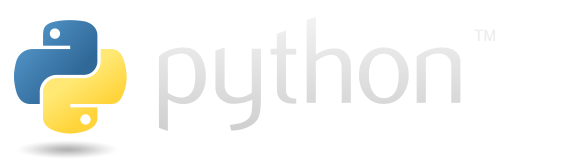

In [2]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from IPython.display import Image  # Для отображения картинки в Colab

# --- ШАГ 1: Найти URL изображения ---
# Сначала нам нужно, как в прошлой лабораторной, найти ссылку на логотип.
base_url = "https://www.python.org/"
response = requests.get(base_url)
soup = BeautifulSoup(response.text, "html.parser")

# Логотип находится в теге <img> внутри тега <a> с href="/".
# --- ЗАДАНИЕ ---
# Найдите тег 'img' и извлеките из него значение атрибута 'src'.
# Сохраните относительный URL в переменную 'relative_logo_url'.
# ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
# На python.org логотип находится внутри <img class="python-logo">
logo_element = soup.find("img", class_="python-logo")
relative_logo_url = logo_element["src"]
# ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

# --- ШАГ 2: Преобразование относительного URL в абсолютный ---
# Ссылка в 'src' относительная ('/images/logo.png').
# Чтобы ее скачать, нужен полный URL.
absolute_logo_url = urljoin(base_url, relative_logo_url)
print(f"Найден абсолютный URL логотипа: {absolute_logo_url}")


# --- ШАГ 3: Скачивание бинарного контента ---
print("Скачиваю изображение...")
# --- ЗАДАНИЕ ---
# Отправьте GET-запрос на 'absolute_logo_url'.
# Ответ для бинарных файлов нужно получать через атрибут .content, а не .text
# Сохраните результат в переменную 'image_content'.
# ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
image_response = requests.get(absolute_logo_url)
if image_response.status_code == 200:
    image_content = image_response.content
    print("Изображение успешно скачано!")
    # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

    # --- ШАГ 4: Сохранение файла на диск ---
    # Используем стандартный синтаксис Python для записи файлов.
    # 'wb' означает "write binary" - запись в бинарном режиме.
    file_name = "logo.png"
    # --- ЗАДАНИЕ ---
    # Откройте файл 'file_name' для записи в бинарном режиме ('wb')
    # и запишите в него 'image_content'.
    # ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
    with open(file_name, "wb") as f:
        f.write(image_content)
    # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲
    print(f"Файл '{file_name}' сохранен в текущую директорию VScode.")

    # Отобразим скачанное изображение прямо в блокноте
    display(Image(file_name))
else:
    print(
        f"Ошибка при скачивании изображения! Статус-код: {image_response.status_code}"
    )

In [3]:
import requests
from bs4 import BeautifulSoup

# --- ШАГ 1: Создание сессии и получение CSRF-токена ---
# requests.Session() - это объект, который будет "помнить" cookies между запросами.
# --- ЗАДАНИЕ ---
# Создайте объект сессии и сохраните его в переменную 'session'.
# ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
session = requests.Session()
# ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

login_url = "http://quotes.toscrape.com/login"

# Сначала делаем GET-запрос, чтобы получить страницу входа и специальный
# "csrf_token" - это защита от межсайтовой подделки запроса.
response_login_page = session.get(login_url)
soup_login = BeautifulSoup(response_login_page.text, "html.parser")

# --- ЗАДАНИЕ ---
# Найдите тег 'input' у которого атрибут name равен 'csrf_token'
# и извлеките из него значение атрибута 'value'.
# ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
csrf_token = soup_login.find("input", {"name": "csrf_token"})["value"]
# ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

print(f"Получен CSRF токен: {csrf_token}")


# --- ШАГ 2: Подготовка данных для POST-запроса ---
# Это данные, которые мы бы ввели в форму на сайте.
# Имена полей ('username', 'password') нужно посмотреть в HTML-коде страницы.
payload = {
    "csrf_token": csrf_token,
    "username": "admin",  # Используем стандартные учетные данные для этого сайта
    "password": "admin",
}


# --- ШАГ 3: Отправка POST-запроса для аутентификации ---
# Мы отправляем POST-запрос на тот же URL, но уже с нашими данными.
# Сессия автоматически сохранит cookies, которые вернет сервер после успешного входа.
# --- ЗАДАНИЕ ---
# Отправьте POST-запрос с помощью объекта 'session'.
# URL: login_url
# Данные: payload
# Сохраните ответ в 'response_post'.
# ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
response_post = session.post(login_url, data=payload)
# ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲


# --- ШАГ 4: Доступ к защищенной странице ---
# Теперь, используя ту же сессию, мы можем зайти на любую страницу сайта,
# и сервер будет "видеть" нас как залогиненного пользователя.
print("\nПробую получить доступ к главной странице после логина...")
response_main_page = session.get("http://quotes.toscrape.com/")
soup_main = BeautifulSoup(response_main_page.text, "html.parser")

# Проверим, видим ли мы кнопку "Logout"
logout_button = soup_main.find("a", href="/logout")

if logout_button:
    print("Успех! Мы авторизованы. Сервер видит кнопку 'Logout'.")
    print(logout_button.text)
else:
    print("Неудача. Авторизация не удалась, кнопка 'Logout' не найдена.")

Получен CSRF токен: aPYIiJKVrQCsqnhSMOGByEZoLultAFxcjXzbemDdNpkTvWwUgRHf

Пробую получить доступ к главной странице после логина...
Успех! Мы авторизованы. Сервер видит кнопку 'Logout'.
Logout


### BeautifulSoup4

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# --- ШАГ 1: Получение HTML ---
url = "http://books.toscrape.com/"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

# --- ШАГ 2: Поиск общего контейнера ---
# Все книги находятся внутри элементов <article> с классом 'product_pod'.
# --- ЗАДАНИЕ ---
# Найдите ВСЕ такие контейнеры с помощью .find_all() и сохраните в 'all_books'.
# ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
all_books = soup.find_all("article", class_="product_pod")
# ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

print(f"Найдено книг на странице: {len(all_books)}")
books_data = []

# --- ШАГ 3: Извлечение данных в цикле ---
for book in all_books:
    # --- ЗАДАНИЕ A: Найти название книги ---
    # Название находится в теге <a> внутри тега <h3>.
    # Нужно извлечь его атрибут 'title'.
    # ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
    title = book.find("h3").find("a")["title"]
    # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

    # --- ЗАДАНИЕ B: Найти цену ---
    # Цена находится в теге <p> с классом 'price_color'.
    # ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
    price = book.find("p", class_="price_color").text
    # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

    # --- ЗАДАНИЕ C: Найти рейтинг ---
    # Рейтинг находится в атрибуте 'class' у тега <p>, который начинается с 'star-rating'.
    # Например: <p class="star-rating Three">. Нам нужно извлечь слово 'Three'.
    # ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
    rating_container = book.find("p", class_="star-rating")
    # Атрибут 'class' возвращает список классов, например, ['star-rating', 'Three']
    rating = rating_container["class"][1]  # Берем второй элемент
    # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

    # Добавляем собранные данные в наш список
    books_data.append({"Title": title, "Price": price, "Rating": rating})

# --- ШАГ 4: Вывод результата ---
df = pd.DataFrame(books_data)
display(df)

Найдено книг на странице: 20


,Title,Price,Rating
0,A Light in the Attic,Â£51.77,Three
1,Tipping the Velvet,Â£53.74,One
2,Soumission,Â£50.10,One
3,Sharp Objects,Â£47.82,Four
4,Sapiens: A Brief History of Humankind,Â£54.23,Five
5,The Requiem Red,Â£22.65,One
6,The Dirty Little Secrets of Getting Your Dream...,Â£33.34,Four
7,The Coming Woman: A Novel Based on the Life of...,Â£17.93,Three
8,The Boys in the Boat: Nine Americans and Their...,Â£22.60,Four
9,The Black Maria,Â£52.15,One


In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# --- ШАГ 1: Получение HTML ---
url = "https://ru.wikipedia.org/wiki/Python"
header = {"User-Agent": "script"}
response = requests.get(url, headers=header)
soup = BeautifulSoup(response.text, "html.parser")
# --- ШАГ 2: Поиск таблицы-инфобокса ---
# Инфобокс - это таблица с классом 'infobox'.
infobox = soup.find("table", class_="infobox")

# --- ШАГ 3: Поиск всех строк с данными ---
# Все строки в таблице - это теги <tr>.
# --- ЗАДАНИЕ ---
# Найдите все теги <tr> внутри 'infobox'.
# ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
rows = infobox.find_all("tr")
# ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

infobox_data = []

# --- ШАГ 4: Навигация по соседним элементам в цикле ---
for row in rows:
    # Нас интересуют строки, где есть и заголовок (<th>) и значение (<td>)
    header = row.find("th")
    data_cell = row.find("td")

    if header and data_cell:
        # --- ЗАДАНИЕ ---
        # Извлеките текст из ячейки-заголовка 'header'.
        # Извлеките текст из ячейки-данных 'data_cell'.
        # Используйте .text.strip() для удаления лишних пробелов и переносов строк.
        # ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
        key = header.text.strip()
        value = data_cell.text.strip()
        # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

        infobox_data.append({"Характеристика": key, "Значение": value})

# --- ШАГ 5: Вывод результата ---
df = pd.DataFrame(infobox_data)
display(df)

,Характеристика,Значение
0,Семантика,"Императивное, процедурное, структурное програм..."
1,Класс языка,Мультипарадигменный язык программирования
2,Тип исполнения,Интерпретируемый
3,Появился в,20 февраля 1991[4]
4,Автор,Гвидо ван Россум[4]
5,Разработчик,Python Software Foundation и Гвидо ван Россум[4]
6,Расширение файлов,".py, .pyc, .pyo (до версии 3.5)"
7,Выпуск,3.14.0 (7 октября 2025)[5][6]
8,Испытал влияние,ABC[7]
9,Лицензия,Python Software Foundation License[4]


**Чему вы научились:**
1.  Искать вложенные элементы (`infobox.find_all('tr')`).
2.  **Навигации по горизонтали:** находить "соседние" теги (`<th>` и `<td>`) внутри общего родителя (`<tr>`).
3.  Использовать `.strip()` для базовой очистки текстовых данных.

---
### **Задача 3: "Дата-клинер" — Очистка и преобразование данных**

**Контекст:** Реальные данные почти всегда "грязные". Цены содержат символы валют, текст — лишние пробелы и переносы, а числа хранятся в виде строк. Профессиональный парсинг включает в себя не только извлечение, но и очистку.

**Ваша миссия:** Перейти на страницу первой книги из каталога, извлечь из нее цену и описание продукта, а затем "очистить" их: цену превратить в число, а из описания убрать лишние символы.

**(Ячейка 3: Код)**

In [6]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import re  # Библиотека для работы с регулярными выражениями

# --- ШАГ 1: Получаем URL первой книги ---
base_url = (
    "http://books.toscrape.com/"  # Важно: для urljoin нужен правильный базовый путь
)
main_page_url = "http://books.toscrape.com/"
response = requests.get(main_page_url)
soup = BeautifulSoup(response.text, "html.parser")

# Находим ссылку на первую книгу
first_book_link = soup.find("h3").find("a")["href"]
book_url = urljoin(base_url, first_book_link)
print(f"URL страницы книги: {book_url}")

# --- ШАГ 2: Переходим на страницу книги и создаем новый "суп" ---
response_book = requests.get(book_url)
soup_book = BeautifulSoup(response_book.text, "html.parser")


# --- ШАГ 3: Извлечение и очистка ЦЕНЫ ---
price_raw = soup_book.find("p", class_="price_color").text
print(f"Сырая строка с ценой: {price_raw}")  # Например, '£51.77'

# --- ЗАДАНИЕ ---
# Напишите код для очистки цены.
# Нужно убрать все символы, кроме цифр и точки, а затем превратить строку в число (float).
# ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
# re.sub(r'[^\d.]', '', price_raw) - эта команда удалит все, что не является цифрой (\d) или точкой (.).
price_clean_str = re.sub(r"[^\d.]", "", price_raw)
price_float = float(price_clean_str)
# ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲
print(f"Очищенная цена (число): {price_float}")
print(f"Тип данных цены: {type(price_float)}")


# --- ШАГ 4: Извлечение и очистка ОПИСАНИЯ ---
# Описание находится в теге <p> сразу ПОСЛЕ тега <div> с id='product_description'.
# Это идеальный случай для использования .find_next_sibling()
# --- ЗАДАНИЕ ---
# Найдите тег <div> с id 'product_description', а затем
# с помощью .find_next_sibling('p') найдите следующий за ним тег <p>.
# ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
description_header = soup_book.find("div", id="product_description")
description_raw = description_header.find_next_sibling("p").text
description_clean = description_raw.strip()
# ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

print(f"\nСырое описание:\n {description_raw[:150]}...")

# Очищаем описание от лишних пробелов и символов
description_clean = description_raw.strip()
print(f"\nОчищенное описание:\n {description_clean[:150]}...")

URL страницы книги: http://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html
Сырая строка с ценой: Â£51.77
Очищенная цена (число): 51.77
Тип данных цены: <class 'float'>

Сырое описание:
 It's hard to imagine a world without A Light in the Attic. This now-classic collection of poetry and drawings from Shel Silverstein celebrates its 20t...

Очищенное описание:
 It's hard to imagine a world without A Light in the Attic. This now-classic collection of poetry and drawings from Shel Silverstein celebrates its 20t...


### Selenium

### Настройка selenium

In [7]:
# Настройка опций для запуска Chrome в "безголовом" режиме (без GUI) в среде Colab
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager


# --- Этот код нужно будет использовать в каждой задаче для инициализации драйвера ---
def setup_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Запуск без открытия окна браузера
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    driver = webdriver.Chrome(
        service=ChromeService(ChromeDriverManager().install()), options=options
    )
    return driver

In [10]:
from selenium.webdriver.common.by import By
import time

# --- ШАГ 1: Инициализация драйвера и переход на страницу ---
driver = setup_driver()
url = "http://quotes.toscrape.com/scroll"
driver.get(url)
print(f"Перешел на страницу: {url}")


# --- ШАГ 2: Логика "бесконечной" прокрутки ---
# Мы будем прокручивать страницу вниз, пока количество цитат не перестанет увеличиваться.
last_height = driver.execute_script("return document.body.scrollHeight")
all_quotes_texts = set()  # Используем set для автоматического удаления дубликатов

while True:
    # --- ЗАДАНИЕ A: Собрать цитаты, видимые на данный момент ---
    # Найдите все элементы с классом 'quote' и добавьте их текст в 'all_quotes_texts'.
    # ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
    quotes_elements = driver.find_elements(By.CLASS_NAME, "quote")
    for quote in quotes_elements:
        all_quotes_texts.add(quote.find_element(By.CLASS_NAME, "text").text)
    # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

    # --- ЗАДАНИЕ B: Прокрутить страницу до самого низа ---
    # Используйте driver.execute_script() для выполнения JavaScript-кода.
    # Команда "window.scrollTo(0, document.body.scrollHeight);" прокручивает страницу вниз.
    # ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

    # Даем странице время на подгрузку нового контента
    time.sleep(3)

    # --- ШАГ 3: Проверка условия выхода из цикла ---
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        print("Достигнут конец страницы. Выхожу из цикла.")
        break  # Выходим, если высота страницы больше не меняется
    last_height = new_height

# --- ШАГ 4: Вывод результата и закрытие браузера ---
print(f"\nСобрано уникальных цитат: {len(all_quotes_texts)}")
print("Пример одной из собранных цитат:")
print(list(all_quotes_texts)[0])

driver.quit()

Перешел на страницу: http://quotes.toscrape.com/scroll
Достигнут конец страницы. Выхожу из цикла.

Собрано уникальных цитат: 100
Пример одной из собранных цитат:
“Beauty is in the eye of the beholder and it may be necessary from time to time to give a stupid or misinformed beholder a black eye.”


In [ ]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

# --- ШАГ 1: Инициализация и переход на сайт ---
driver = setup_driver()
# ВАЖНО: Структура и селекторы на живых сайтах могут меняться!
# Этот код актуален на момент написания.
url = "https://www.aviasales.ru/"
driver.get(url)
print(f"Перешел на страницу: {url}")
time.sleep(2)  # Небольшая пауза, чтобы страница прогрузилась

# --- ШАГ 2: Ввод данных в форму поиска ---
try:
    # --- ЗАДАНИЕ A: Ввести город отправления ---
    # Найдите поле ввода для города отправления (id='origin').
    # Очистите его (.clear()) и введите "Москва" (.send_keys()).
    # ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
    origin = driver.find_element(By.NAME, "Откуда")
    origin.clear()
    origin.send_keys("Москва")
    # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲
    time.sleep(1)  # Пауза, чтобы появился выпадающий список

    # --- ЗАДАНИЕ B: Ввести город назначения ---
    # По аналогии найдите поле назначения (id='destination') и введите "Санкт-Петербург".
    # ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
    destination = driver.find_element(By.NAME, "Куда")
    destination.clear()
    destination.send_keys("Мюнхен")
    # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲
    time.sleep(1)

    # --- ЗАДАНИЕ C: Нажать на кнопку поиска ---
    # Кнопка поиска часто имеет сложный селектор.
    # Будем искать по тексту "Найти билеты" внутри тега <div>
    # XPath-селектор для этого: "//div[text()='Найти билеты']"
    # ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
    search_button = driver.find_element(By.XPATH, "//div[text()='Найти билеты']")
    search_button.click()
    # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

    # --- ШАГ 3: Ожидание и извлечение результатов ---
    print("Нажал 'Найти'. Жду появления результатов...")
    # --- ЗАДАНИЕ D: Дождаться загрузки первого билета ---
    # Это ключевой шаг. Мы ждем до 20 секунд, пока на странице не появится
    # элемент, сигнализирующий о загрузке результатов (например, контейнер с ценой).
    # Используем WebDriverWait и Expected Conditions (EC).
    # Ищем первый элемент с атрибутом 'data-test-id="ticket-card"'.
    # ▼▼▼ ВАШ КОД ЗДЕСЬ ▼▼▼
    wait = WebDriverWait(driver, 20)
    first_ticket = wait.until(
        EC.presence_of_element_located(
            (By.CSS_SELECTOR, "[data-test-id='ticket-card']")
        )
    )
    # ▲▲▲ ВАШ КОД ЗДЕСЬ ▲▲▲

    print("Результаты загружены!")
    # Извлекаем цену из первого найденного билета
    price = first_ticket.find_element(By.CSS_SELECTOR, "[data-test-id='price']").text
    print(f"Цена первого найденного билета: {price}")

finally:
    # --- ШАГ 4: Обязательное закрытие браузера ---
    driver.quit()

Перешел на страницу: https://www.aviasales.ru/


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[name="Откуда"]"}
  (Session info: chrome=141.0.7390.108); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#nosuchelementexception
Stacktrace:
0   chromedriver                        0x00000001031e75f0 cxxbridge1$str$ptr + 2894960
1   chromedriver                        0x00000001031df52c cxxbridge1$str$ptr + 2861996
2   chromedriver                        0x0000000102d055ec _RNvCs47EqcsrPRmA_7___rustc35___rust_no_alloc_shim_is_unstable_v2 + 74324
3   chromedriver                        0x0000000102d4cfb4 _RNvCs47EqcsrPRmA_7___rustc35___rust_no_alloc_shim_is_unstable_v2 + 367644
4   chromedriver                        0x0000000102d8e458 _RNvCs47EqcsrPRmA_7___rustc35___rust_no_alloc_shim_is_unstable_v2 + 635072
5   chromedriver                        0x0000000102d41178 _RNvCs47EqcsrPRmA_7___rustc35___rust_no_alloc_shim_is_unstable_v2 + 318944
6   chromedriver                        0x00000001031ab33c cxxbridge1$str$ptr + 2648508
7   chromedriver                        0x00000001031ae918 cxxbridge1$str$ptr + 2662296
8   chromedriver                        0x000000010318bdbc cxxbridge1$str$ptr + 2520124
9   chromedriver                        0x00000001031af200 cxxbridge1$str$ptr + 2664576
10  chromedriver                        0x000000010317d52c cxxbridge1$str$ptr + 2460588
11  chromedriver                        0x00000001031cebec cxxbridge1$str$ptr + 2794092
12  chromedriver                        0x00000001031ced70 cxxbridge1$str$ptr + 2794480
13  chromedriver                        0x00000001031df178 cxxbridge1$str$ptr + 2861048
14  libsystem_pthread.dylib             0x00000001841bec0c _pthread_start + 136
15  libsystem_pthread.dylib             0x00000001841b9b80 thread_start + 8


### **Контрольные вопросы по библиотекам для парсинга**

#### **Блок 1: Библиотека `requests` ("Курьер")**

Эти вопросы проверяют ваше умение получать данные с сервера.

1.  **Фундаментальный вопрос:** В чем основная задача библиотеки `requests`? Что она делает, а чего, наоборот, делать **не умеет** (например, в контексте JavaScript)?
2.  **Типы запросов:** В чем принципиальная разница между `GET` и `POST` запросами? В какой из наших лабораторных задач мы использовали `POST` и для какой цели?
3.  **Объект ответа:** Вы выполнили команду `response = requests.get(url)`. Какие три важнейших атрибута объекта `response` вы будете использовать и для чего каждый из них предназначен (`status_code`, `text`, `content`)?
4.  **Обработка ошибок:** Почему проверка `response.status_code == 200` является обязательным шагом в любом надежном парсере? Что означает код `404`? А код `403`?
5.  **Работа с API:** Почему для получения данных от API (как в задаче с GitHub) мы использовали метод `response.json()`, а не просто брали `response.text`? В чем преимущество такого подхода?
6.  **Сессии:** Объясните своими словами, что такое `requests.Session()`. Какую проблему решает объект сессии, и почему без него не удалось бы выполнить задачу с авторизацией на сайте?
сохраняет cookies и заголовки между запросами —
это нужно для авторизации и последовательных запросов как у «настоящего» пользователя.
7.  **Параметры запроса:** Как с помощью `requests` передать в URL GET-параметры (например, `?sort=date&page=2`) без ручного формирования строки URL? Какой аргумент функции `get()` для этого используется?
requests.get(url, params={'sort': 'date', 'page': 2})
---

#### **Блок 2: Библиотека `BeautifulSoup` ("Навигатор")**

Эти вопросы проверяют ваше умение разбирать HTML-код и находить в нем нужные данные.

8.  **Основное назначение:** Какую проблему решает `BeautifulSoup`? Что она принимает на вход и что отдает на выходе?
9.  **Ключевое различие:** В чем фундаментальная разница между методами `.find()` и `.find_all()`? Приведите пример, когда нужно использовать один, а когда — другой.
10. **Синтаксис поиска:** Как найти тег `<p>` с CSS-классом `price_color`? Почему в коде мы пишем `class_` с нижним подчеркиванием, а не просто `class`?
soup.find('p', class_='price_color')
11. **Извлечение данных:** У вас есть объект тега, сохраненный в переменной `tag`. Как из него извлечь:
    *   Весь видимый текст внутри него? tag.text  
    *   Значение атрибута `href`? tag['href'] 
12. **Вложенный поиск:** Ваш парсер нашел общий контейнер товара (`<div class="product">`). Как продолжить поиск и найти цену, которая находится **внутри** этого контейнера? Напишите примерный код.
container = soup.find('div', class_='product')
price = container.find('p', class_='price_color')
13. **Продвинутая навигация:** Представьте, что вы нашли заголовок `<h2>Описание</h2>`. Само описание находится в следующем за ним теге `<p>`. Какой метод `BeautifulSoup` позволит вам найти этот "соседний" тег, не начиная поиск заново от корня документа?
soup.find('h2', text='Описание').find_next_sibling('p')

14. **Очистка данных:** Почему простого извлечения `.text` часто недостаточно для реальных задач? Какие две стандартные операции по очистке текста вы применяли в лабораторных работах?
re.sub(r'\s+', ' ', text), strip
---

#### **Блок 3: Библиотека `Selenium` ("Робот-пользователь")**

Эти вопросы проверяют ваше понимание работы с динамическими сайтами и автоматизацией браузера.

15. **Главный вопрос:** Назовите основную причину, по которой мы вынуждены использовать `Selenium`, а не `requests`. Какую технологию `Selenium` умеет обрабатывать, а `requests` — нет?
16. **Проблема синхронизации:** Почему использование `time.sleep()` для ожидания загрузки элементов на странице является плохой практикой? Каков правильный, надежный способ дождаться появления элемента?
17. **Явные ожидания (Explicit Waits):** Объясните своими словами, что делают эти три строки кода:
    ```python
    wait = WebDriverWait(driver, 10)
    element = wait.until(
        EC.presence_of_element_located((By.CLASS_NAME, 'price'))
    )
    ```
18. **Взаимодействие с формами:** Опишите последовательность из трех основных действий, которые нужно совершить с помощью `Selenium`, чтобы ввести текст в поле поиска и нажать на кнопку.
Найти поле (find_element).
Ввести текст (send_keys('поиск')).
Найти и нажать кнопку (click()).
19. **Исполнение JavaScript:** Для чего в задаче с "бесконечным свитком" мы использовали команду `driver.execute_script()`? Можно ли было добиться того же результата другим методом `Selenium`?
20. **Интеграция библиотек:** В какой момент работы парсера на `Selenium` имеет смысл передать управление библиотеке `BeautifulSoup`? Что для этого нужно получить от `driver` и как это сделать?
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')
21. **Завершение работы:** Почему команда `driver.quit()` является обязательной в конце скрипта? Что произойдет, если ее не вызывать?

---

#### **Блок 4: Синтез и сценарии (Проверка общего понимания)**

22. **Выбор инструмента:** Вам нужно спарсить три сайта:
    *   А) Таблицу курсов валют со страницы Центробанка. req+bs4
    *   Б) Ленту комментариев на YouTube, которая подгружается при прокрутке. - selenium
    *   В) Данные о погоде с публичного погодного API. - requests
    Какой основной инструмент (`requests`, `bs4`, `Selenium`) вы выберете для **каждой** из этих задач и почему?

23. **Отладка:** Ваш парсер на `BeautifulSoup` вчера работал, а сегодня перестал, выдавая ошибку `AttributeError: 'NoneType' object has no attribute 'text'`. Назовите самую вероятную причину этой проблемы. Каков ваш первый шаг для диагностики?
сайт изменил структуру, класс или тег.
24. **Этика парсинга:** Что такое файл `robots.txt` на сайте и почему его рекомендуется проверять перед запуском массового сбора данных?
Файл на сайте, который указывает,
какие разделы можно или нельзя сканировать ботам.
Проверка — этическая норма и защита от блокировки/нарушения правил.